# DD2437 Lab 3, Hopfield networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data
x1 = np.array([-1, -1, 1, -1, 1, -1, -1, 1])
x2 = np.array([-1, -1, -1, -1, -1, 1, -1, -1])
x3 = np.array([-1, 1, 1, -1, -1, 1, -1, 1])

In [3]:
def sign(x):
    return np.where(x < 0, -1, 1)

In [4]:
def calc_weights(pattern, normalize=False):
    if normalize:
        return pattern.T.dot(pattern)/pattern.shape[1]
    return pattern.T.dot(pattern)

In [5]:
def update_rule(pattern, weights):
    return sign(np.dot(pattern, weights))

In [6]:
pattern = np.c_[x1, x2, x3].T
weights = calc_weights(pattern)
(update_rule(pattern, weights) == pattern).all()

True

Make sure that the above says true, this means we've initialized the hopfield network to maintain our x-input as fixed points. Not modifying them in the update step.

## 3.1 Convergence and attractors

In [7]:
x1d = np.array([1, -1, 1, -1, 1, -1, -1, 1])
x2d = np.array([1, 1, -1, -1, -1, 1, -1, -1])
x3d = np.array([1, 1, 1, -1, 1, 1, -1, 1])
patterns_mod = np.c_[x1d, x2d, x3d].T

In [8]:
def update_til_converge(pattern, weights, 
                        return_iterations=False):
    updated = pattern
    prev = np.zeros(pattern.shape)
    iterations = 0
    while not (updated == prev).all():
        prev = updated
        updated = update_rule(prev, weights)
        iterations += 1

    if return_iterations:
        return updated, iterations
    
    return updated

In [9]:
updated = update_til_converge(patterns_mod, weights)

In [10]:
updated == pattern

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True, False,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

x2d does not converge to the stored pattern, the other two do however.

In [11]:
def examine_states(weights):
    N = weights.shape[0]
    attractors = []
    for val in range(2**N):
        bin_val = format(val, '0{}b'.format(N))
        bin_list = np.array([int(b) for b in bin_val])
        input_val = np.where(bin_list == 1, 1, -1)
        attractors.append(update_til_converge(input_val, weights))
    return attractors

In [12]:
attractors = examine_states(weights)
attractors = [tuple(attractor) for attractor in attractors]

In [13]:
from collections import Counter
import operator

counts = dict(Counter(attractors))
# counts = sorted(counts.items(), key=operator.itemgetter(1))
# print(counts, len(counts))
for key, count in counts.items():
    if (np.array(key) == x1).all():
        print("x1: {}".format(count))
    elif (np.array(key) == x2).all():
        print("x2: {}".format(count))
    elif (np.array(key) == x3).all():
        print("x3: {}".format(count))
    else:
        print(key, count)

x2: 20
(-1, -1, 1, -1, -1, 1, -1, 1) 7
(-1, -1, 1, -1, 1, 1, -1, 1) 15
(-1, -1, -1, -1, 1, -1, -1, -1) 1
x1: 20
(1, -1, -1, 1, 1, -1, 1, -1) 32
(1, 1, -1, 1, -1, 1, 1, -1) 36
(1, 1, 1, 1, 1, -1, 1, 1) 57
x3: 42
(-1, 1, -1, -1, -1, 1, -1, -1) 4
(1, 1, -1, 1, 1, -1, 1, -1) 12
(-1, 1, 1, -1, 1, -1, -1, 1) 4
(1, 1, 1, 1, -1, 1, 1, 1) 4
(1, 1, -1, 1, 1, 1, 1, -1) 2


In [14]:
def examine_distant_states(weights):
    N = weights.shape[0]
    convergence_times = {}
    for val in range(2**N):
        bin_val = format(val, '0{}b'.format(N))
        bin_list = np.array([int(b) for b in bin_val])
        input_val = np.where(bin_list == 1, 1, -1)
        val, iterations = update_til_converge(input_val, weights, return_iterations=True)
        convergence_times[bin_val] = iterations
    return convergence_times

In [15]:
def get_min_dist(bin_val, baselines):
    bin_list = np.array([int(b) for b in bin_val])
    pattern = np.where(bin_list == 1, 1, -1)
    min_dist = pattern.shape[0]
    
    for baseline in baselines:
        min_dist = min(min_dist, list(pattern == baseline).count(False))
    return min_dist

In [16]:
convergence_times = examine_distant_states(weights)
for val, iterations in convergence_times.items():
    min_dist = get_min_dist(val, [x1, x2, x3])
    if min_dist >= x1.shape[0]/2:
        pass
#         print(min_dist, iterations)

1. Did all the patterns converge towards stored patterns?

*They converge, but x2d does not converge to x2 (nor x1, x3)*

2. How many attractors are there in this network? Hint: automate the searching.

*14 in total, see In: 13*

3. What happens when you make the starting pattern even more dissimilar to the stored ones (e.g. more than half is wrong)?

*The pattern converges to a different attractor.*

## 3.2 Sequential Update

In [17]:
def get_pict_data():
    filename = "pict.dat"
    pictsdata = []
    with open(filename) as f:
        pictsdata = [int(p_val) for p_val in f.read().split(',')]
    return pictsdata

In [18]:
PICT_DIM = 1024
picts_raw = get_pict_data()
NO_PICTS = int(len(picts_raw)/PICT_DIM)
IMG_DIMS = (32, 32)

picts = []
for ndx in range(NO_PICTS):
    picts.append(picts_raw[PICT_DIM*ndx : PICT_DIM*(ndx+1)])

In [19]:
def print_image(image, dims):
    imagedata = np.where(image == 1, 1, 0).reshape(dims)
    plt.imshow(imagedata)

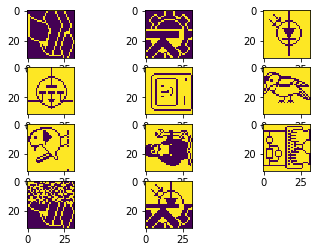

In [20]:
# Print the data
fig = plt.figure()
for ndx, pict in enumerate(picts):
    fig.add_subplot(4, 3, ndx+1)
    print_image(np.array(pict), IMG_DIMS)

In [21]:
p1 = np.array(picts[0])
p2 = np.array(picts[1])
p3 = np.array(picts[2])
p4 = np.array(picts[3])
p5 = np.array(picts[4])
p6 = np.array(picts[5])
p7 = np.array(picts[6])
p8 = np.array(picts[7])
p9 = np.array(picts[8])
p10 = np.array(picts[9])
p11 = np.array(picts[10])

pattern = np.c_[p1, p2, p3].T
weights = calc_weights(pattern)

**Check that the three patterns are stable:**

In [22]:
updated, iterations = update_til_converge(
    pattern, weights, return_iterations=True)

print("Network converged to pattern={} after {} iteration(s)".format(
    (updated == pattern).all(), iterations))

Network converged to pattern=True after 1 iteration(s)


**Can the network complete a degraded pattern?**

p10 converged to p1=True after 2 iteration(s)


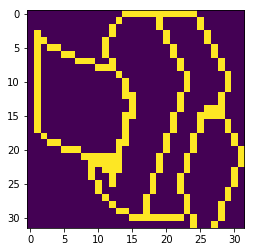

In [23]:
updated, iterations = update_til_converge(p10, weights, True)
print("p10 converged to p1={} after {} iteration(s)".format(
    (updated == p1).all(), iterations))

print_image(updated, IMG_DIMS)

p11 converged to p2=False after 3 iteration(s)


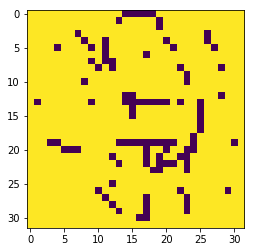

In [24]:
updated, iterations = update_til_converge(p11, weights, True)
print("p11 converged to p2={} after {} iteration(s)".format(
    (updated == p2).all(), iterations))

print_image(updated, IMG_DIMS)

**Clearly convergence is practically instantaneous. What happens if we select units randomly?**

In [25]:
from random import randrange

def random_update_til_converge(pattern, weights, 
                               return_iterations=False,
                               print_image_interval=None):
    #print((pattern == p10).all())
    mul = 30
#     updated = np.ones(pattern.shape)
    updated = np.array(pattern)
    prev = np.zeros(pattern.shape)
    iterations = 0
    fig = plt.figure()
    for ndx in range(print_image_interval*mul):
#     while not (p3 == updated).all():
        prev = updated
        
        random_i = randrange(weights.shape[0])
        updated[random_i] = update_rule(prev, weights[random_i,:])
        
        iterations += 1
        
        if ndx % print_image_interval == 0:
            fig.add_subplot(6, 5, int(ndx/print_image_interval)+1)
            print_image(updated, IMG_DIMS)

    fig.savefig("plot.pdf")
    
    if return_iterations:
        return updated, iterations
    
    return updated

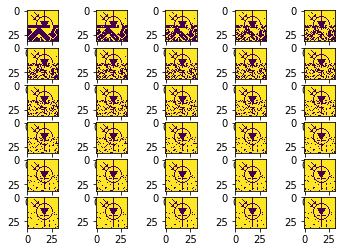

In [26]:
updated = random_update_til_converge(p11, weights, False, 100)

In [27]:
(updated == p3).all()

False

## 3.3 Energy

In [28]:
def state_energy(pattern, weights):
    return -np.dot(pattern.T, weights).dot(pattern)

- What is the energy at the different attractors?
- What is the energy at the points of the distorted patterns?

In [29]:
print("Pict: Energy")
for ndx, pict in enumerate(picts):
    print("p{:2}: {:2.2e}".format(ndx+1, state_energy(np.array(pict), weights)))

Pict: Energy
p 1: -1.47e+06
p 2: -1.40e+06
p 3: -1.50e+06
p 4: -7.38e+05
p 5: -5.39e+05
p 6: -7.00e+05
p 7: -7.02e+05
p 8: -1.76e+05
p 9: -2.74e+05
p10: -4.26e+05
p11: -1.78e+05


In [30]:
def update_til_converge_with_energy(pattern, weights, max_iterations=None):
    updated = pattern
    prev = np.zeros(pattern.shape)
    energies = []
    iterations = 0
    while not (updated == prev).all():
        prev = updated
        updated = update_rule(prev, weights)
        energies.append(state_energy(prev, weights))
        iterations += 1
        if iterations == max_iterations:
            break
    
    return updated, energies

- Follow how the energy changes from iteration to iteration when you use the sequential update rule to approach an attractor.

Text(0,0.5,'Energy')

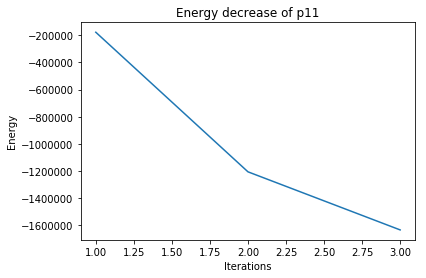

In [31]:
updated, energies = update_til_converge_with_energy(p11, weights)
plt.plot(range(1, 1+len(energies)), energies)
plt.title("Energy decrease of p11")
plt.xlabel("Iterations")
plt.ylabel("Energy")

Text(0,0.5,'Energy')

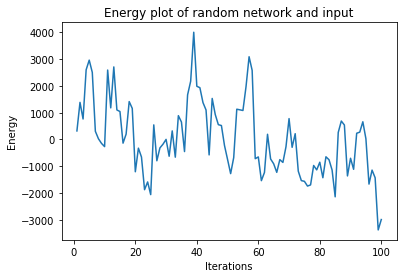

In [32]:
weights = np.random.normal(0,1, (PICT_DIM, PICT_DIM))
pattern = np.random.normal(0,1, PICT_DIM)
updated, energies = update_til_converge_with_energy(
    pattern, weights, 100)
plt.plot(range(1, 1+len(energies)), energies)
plt.title("Energy plot of random network and input")
plt.xlabel("Iterations")
plt.ylabel("Energy")

- Make the weight matrix symmetric (e.g. by setting w=0.5*(w+w')). What happens now? Why?

*The energy oscillates between two states* WHY?

In [33]:
weights = 0.5*(weights+weights.T)

Text(0,0.5,'Energy')

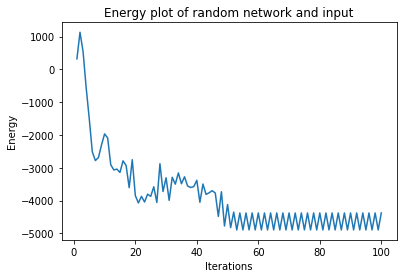

In [34]:
updated, energies = update_til_converge_with_energy(
    pattern, weights, 100)
plt.plot(range(1, 1+len(energies)), energies)
plt.title("Energy plot of random network and input")
plt.xlabel("Iterations")
plt.ylabel("Energy")

In [35]:
(weights == weights.T).all()

True

## 3.4 Distortion Resistance

In [36]:
# Init network
picts_raw = get_pict_data()
picts = []
for ndx in range(NO_PICTS):
    picts.append(picts_raw[PICT_DIM*ndx : PICT_DIM*(ndx+1)])

p1 = np.array(picts[0])
p2 = np.array(picts[1])
p3 = np.array(picts[2])
p4 = np.array(picts[3])
p5 = np.array(picts[4])
p6 = np.array(picts[5])
p7 = np.array(picts[6])
p8 = np.array(picts[7])
p9 = np.array(picts[8])
p10 = np.array(picts[9])
p11 = np.array(picts[10])

pattern = np.c_[p1, p2, p3].T
weights = calc_weights(pattern)

In [37]:
def add_noise(pattern, ratio):
    new_pattern = np.array(pattern)
    indices = np.random.choice(np.arange(len(pattern)), 
                               size=int(ratio*len(pattern)),
                               replace=False)
    new_pattern[indices] = np.where(pattern[indices] == 1, -1, 1)
    return new_pattern

In [40]:
# updated, iterations = update_til_converge(add_noise(p1, 0.2), weights, True)
ITERATIONS = 1
PATTERNS = {"p1": p1, "p2": p2, "p3": p3}
converges = {}
iterations_count = {}
ratios = np.arange(0, 1.0, 0.01)

for pattern in PATTERNS:
    print(pattern)
    converges[pattern] = []
    iterations_count[pattern] = []
    
    for ratio in ratios:
        ratio_sum = 0.0
        iterations_sum = 0.0
    
        for iteration in range(ITERATIONS):
            noise_pattern = add_noise(PATTERNS[pattern], ratio)
            updated, update_iters = update_til_converge(
                noise_pattern, weights, True)
            ratio_sum += (updated == PATTERNS[pattern]).all()
            iterations_sum += update_iters
        
        converges[pattern].append(ratio_sum/ITERATIONS)
        iterations_count[pattern].append(iterations_sum/ITERATIONS)

p1
p2
p3


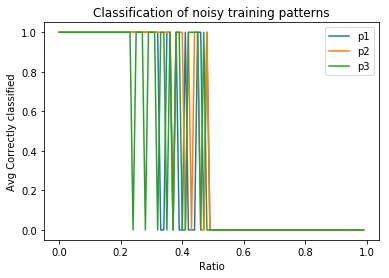

In [41]:
fig = plt.figure()

# fig.add_subplot(131)
plt.plot(ratios, converges['p1'], label='p1')
# fig.add_subplot(132)
plt.plot(ratios, converges['p2'], label='p2')
# fig.add_subplot(133)
plt.plot(ratios, converges['p3'], label='p3')

plt.legend()
plt.xlabel("Ratio")
plt.ylabel("Avg Correctly classified")
plt.title("Classification of noisy training patterns")
plt.savefig("")

In [42]:
max_ind = {p:0 for p in PATTERNS}
for pattern in PATTERNS:
    for ndx, classification in enumerate(converges[pattern]):
        if classification == 1.0:
            max_ind[pattern] = ndx
        elif classification != 1.0:
            break

In [43]:
max_ind

{'p1': 32, 'p2': 36, 'p3': 23}

Text(0.5,1,'Classification of noisy training patterns')

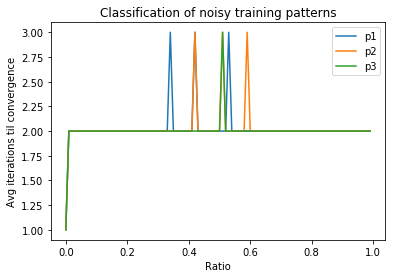

In [44]:
# fig = plt.figure()

# fig.add_subplot(131)
plt.plot(ratios, iterations_count['p1'], label='p1')
# fig.add_subplot(132)
plt.plot(ratios, iterations_count['p2'], label='p2')
# fig.add_subplot(133)
plt.plot(ratios, iterations_count['p3'], label='p3')

plt.legend()
plt.xlabel("Ratio")
plt.ylabel("Avg iterations til convergence")
plt.title("Classification of noisy training patterns")

## 3.5 Capacity

In [273]:
# Init network
picts_raw = get_pict_data()
picts = []
for ndx in range(NO_PICTS):
    picts.append(picts_raw[PICT_DIM*ndx : PICT_DIM*(ndx+1)])

p1 = np.array(picts[0])
p2 = np.array(picts[1])
p3 = np.array(picts[2])
p4 = np.array(picts[3])
p5 = np.array(picts[4])
p6 = np.array(picts[5])
p7 = np.array(picts[6])
p8 = np.array(picts[7])
p9 = np.array(picts[8])
p10 = np.array(picts[9])
p11 = np.array(picts[10])

pattern = np.c_[p1, p2, p3, p4].T
weights = calc_weights(pattern)

In [200]:
updated = real_random_update_til_converge(p1, weights, 
                               return_iterations=False)

In [130]:
def random_update_til_converge_without_plot(pattern, weights, 
                               return_iterations=False,
                               print_image_interval=None):
    #print((pattern == p10).all())
    mul = 30
#     updated = np.ones(pattern.shape)
    updated = np.array(pattern)
    prev = np.zeros(pattern.shape)
    iterations = 0
    for ndx in range(print_image_interval*mul):
#     while not (p3 == updated).all():
        prev = updated
        
        random_i = randrange(weights.shape[0])
        updated[random_i] = update_rule(prev, weights[random_i,:])
        
        iterations += 1
        
    if return_iterations:
        return updated, iterations
    
    return updated

In [252]:
def real_random_update_til_converge(pattern, weights, 
                        return_iterations=False):
    updated = pattern
    prev = np.zeros(pattern.shape)
    iterations = 0
    while not (updated == prev).all():
        prev = updated        
        random_i = randrange(weights.shape[0])
        updated[random_i] = update_rule(prev, weights[random_i,:])
        
        iterations += 1
        
    if return_iterations:
        return updated, iterations
    
    return updated

In [253]:
# updated, iterations = update_til_converge(add_noise(p1, 0.2), weights, True)

PATTERNS = {"p1": p1, "p2": p2, "p3":p3, "p4":p4}
MAX_RATIO = 0.1

def convergence_of_noisy_patterns(patterns_dict, weights, max_ratio, iterations=1000):
    converges = {}
    iterations_count = {}
    ratios = np.arange(0, max_ratio, 0.01)

    for pattern in patterns_dict:
        print(pattern)
        converges[pattern] = []
        iterations_count[pattern] = []

        for ratio in ratios:
            ratio_sum = 0.0
            iterations_sum = 0.0

            for iteration in range(iterations):
                noise_pattern = add_noise(patterns_dict[pattern], ratio)
                updated, update_iters = real_random_update_til_converge(
                    noise_pattern, weights, True)
                ratio_sum += (updated == patterns_dict[pattern]).all()
                iterations_sum += update_iters

            converges[pattern].append(ratio_sum/iterations)
            iterations_count[pattern].append(iterations_sum/iterations)
        
    fig = plt.figure()
    for val in patterns_dict.keys():
        plt.plot(ratios, converges[val], label=val)
    plt.legend()
    plt.xlabel("Ratio")
    plt.ylabel("Avg Correctly classified")
    plt.title("Classification of noisy training patterns")
    return fig

p1
p2
p3
p4


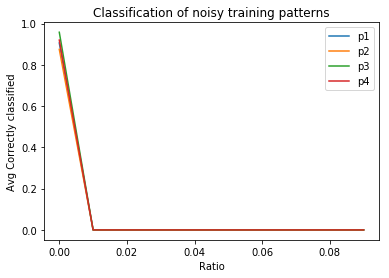

In [255]:
fig_p4 = convergence_of_noisy_patterns(PATTERNS, weights, MAX_RATIO, iterations=1000)

We used the function 'real_update_til_convergence' since our patterns weren't converging with a fixed number of iterations.

For 4 stored patterns, even without distorsion, our network sometimes doesn't recall these 4 patterns (~13%error). Furthermore, it doesn't remember the patterns at all if they have more than a 1% distorsion. 

### Adding p5, p6, p7:

In [256]:
pattern = np.c_[p1, p2, p3, p4, p5].T
weights = calc_weights(pattern)

p1
p2
p3
p4
p5


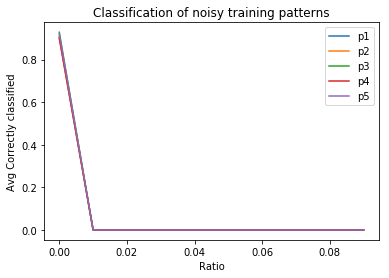

In [258]:
PATTERNS = {"p1": p1, "p2": p2, "p3":p3, "p4":p4, "p5":p5}
fig_p5 = convergence_of_noisy_patterns(PATTERNS, weights, MAX_RATIO, iterations=1000)

In [217]:
pattern = np.c_[p1, p2, p3, p4, p5, p6].T
weights = calc_weights(pattern)

p1
p2
p3
p4
p5
p6


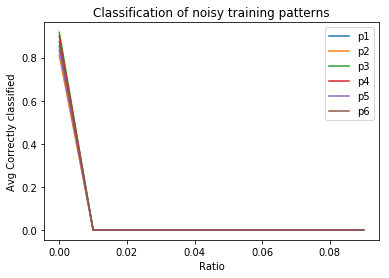

In [218]:
PATTERNS = {"p1": p1, "p2": p2, "p3":p3, "p4":p4, "p5":p5, "p6":p6}
fig_p6 = convergence_of_noisy_patterns(PATTERNS, weigths, MAX_RATIO, iterations=1000)

In [259]:
pattern = np.c_[p1, p2, p3, p4, p5, p6, p7].T
weights = calc_weights(pattern)

p1
p2
p3
p4
p5
p6
p7


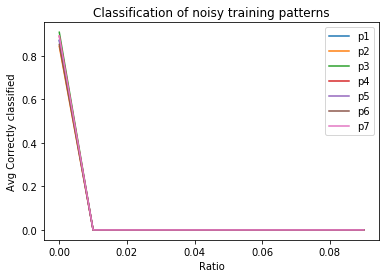

In [261]:
PATTERNS = {"p1": p1, "p2": p2, "p3":p3, "p4":p4, "p5":p5, "p6":p6, "p7":p7}
fig_p7 = convergence_of_noisy_patterns(PATTERNS, weights, MAX_RATIO, iterations=1000)

Even when storing 7 patterns, we have around 10% error. The limit of distortion allowed by our model is still 1%. Only 3 patterns can be stored safely (ie 100% accuracy over iterations). We could try taking different 3 patterns to see if the network can store any triplet. 

### Random patterns instead of the pictures :

In [325]:
def create_random_pattern(Nb_of_patterns, length):
    pattern = np.random.rand(Nb_of_patterns, length)
    pattern = np.where(pattern > 0.5, 1, -1)
    return pattern

In [336]:
NUMBER_OF_PATTERNS = 100

p_random = create_random_pattern(NUMBER_OF_PATTERNS, 1024)
weights = calc_weights(p_random)

In [337]:
def matrix_to_dict(pattern_matrix):
    pattern_dict = {}
    for i in range(1, NUMBER_OF_PATTERNS+1):
        pattern_dict['p'+str(i)+'_r'] = pattern_matrix[i-1,:]
    
    return pattern_dict

In [338]:
PATTERNS = matrix_to_dict(p_random)

p1_r
p2_r
p3_r
p4_r
p5_r
p6_r
p7_r
p8_r
p9_r
p10_r
p11_r
p12_r
p13_r
p14_r
p15_r
p16_r
p17_r
p18_r
p19_r
p20_r
p21_r
p22_r
p23_r
p24_r
p25_r
p26_r
p27_r
p28_r
p29_r
p30_r
p31_r
p32_r
p33_r
p34_r
p35_r
p36_r
p37_r
p38_r
p39_r
p40_r
p41_r
p42_r
p43_r
p44_r
p45_r
p46_r
p47_r
p48_r
p49_r
p50_r
p51_r
p52_r
p53_r
p54_r
p55_r
p56_r
p57_r
p58_r
p59_r
p60_r
p61_r
p62_r
p63_r
p64_r
p65_r
p66_r
p67_r
p68_r
p69_r
p70_r
p71_r
p72_r
p73_r
p74_r
p75_r
p76_r
p77_r
p78_r
p79_r
p80_r
p81_r
p82_r
p83_r
p84_r
p85_r
p86_r
p87_r
p88_r
p89_r
p90_r
p91_r
p92_r
p93_r
p94_r
p95_r
p96_r
p97_r
p98_r
p99_r
p100_r


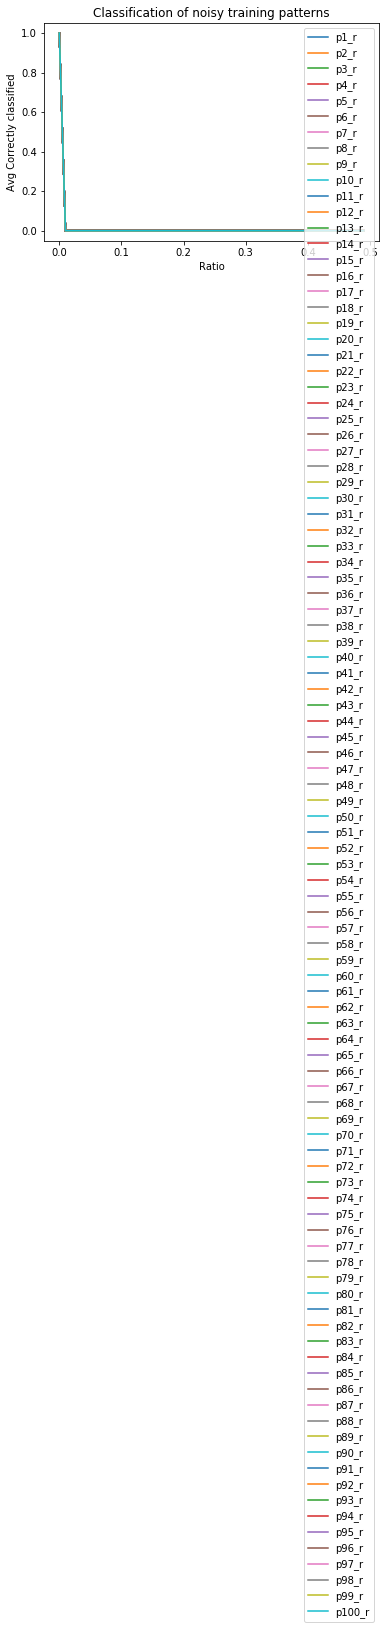

In [339]:
MAX_RATIO = 0.5
fig_r3 = convergence_of_noisy_patterns(PATTERNS, weights, MAX_RATIO, iterations=1000)